In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
from tqdm.notebook import tqdm

from data_processing.GameFeaturesGenerator import GameFeaturesGenerator
from data_processing.TournamentDataProcessor import TournamentDataProcessor
from data_processing.LeaguesDataProcessor import LeaguesDataProcessor
from data_processing.utils.download_functions import *

In [2]:
os.chdir('esports-data')
os.listdir()

['2021_raw_game_data',
 'leagues.json',
 'mapping_data.json',
 'players.json',
 'teams.json',
 'tournaments.json']

In [3]:
# Read in tournament data
with open("tournaments.json", "r") as json_file:
   tournament_data_all = json.load(json_file)

# Read in mappings data
with open("mapping_data.json", "r") as json_file:
   mappings_data = json.load(json_file)
   
mappings = {
   esports_game["esportsGameId"]: esports_game for esports_game in mappings_data
}

# Set up LeaguesDataProcessor
leagues_data_processor = LeaguesDataProcessor()

# Only retrieve LCS tournament data ['lcs_summer_2023']
# tournament_data = [x for x in tournament_data_all if x['slug']=='lec_summer_2023'][0]# Open basic files
tournament_data = [x for x in tournament_data_all if x['slug']=='msi_2021'][0]

In [4]:
tournament_data_processor = TournamentDataProcessor(tournament_data, leagues_data_processor.leagues_df)
tournament_data_processor.get_tournament_stages()

[['Regular Season', 1], ['Playoffs', 1]]

In [5]:
training_data, testing_data = tournament_data_processor.get_tournament_data(training_stages=['Regular Season'], testing_stages=['Playoffs'])
# training_data, testing_data = tournament_data_processor.get_tournament_data(training_stages=[], testing_stages=[])
print(len(training_data))
print(len(testing_data))

90
34


In [10]:
training_data.head() # Need to add the time for sorting purposes 
# [match_id, esportsGameId, league, team_id_1, team_id_2, outcome_1, outcome_2]

,match_id,esportsGameId,league,team_id_1,outcome_1,team_id_2,outcome_2
0,106269680921743317,106269680921743318,LEC,101383793572656373,0,101383793569248484,1
1,106269680921743319,106269680921743320,LEC,101383793569248484,0,98767991866488695,1
2,106269680921743321,106269680921743322,LEC,98767991926151025,1,101383793569248484,0
3,106269680921743323,106269680921743324,LEC,101383793569248484,0,103461966965149786,1
4,106269680921743325,106269680921743326,LEC,98767991940181526,1,101383793569248484,0


In [9]:
game_id

'106269680921743320'

In [7]:
directory = "games"
if not os.path.exists(directory):
   os.makedirs(directory)

# Load each game and process them
game_rows = []
# for i in tqdm(range(len(training_data))):
for i in range(2):
    try:
        game_id = training_data.iloc[i]['esportsGameId']
        game_mapping_data = mappings[game_id]
        platform_game_id = game_mapping_data['platformGameId']
        download_gzip_and_write_to_json(f"{directory}/{platform_game_id}")
        with open(f"games/{platform_game_id}.json", "r") as json_file:
            game_data = json.load(json_file)
    except KeyError:
        print(f"Match {game_id} was not found")
        continue
    try:
        game_features = GameFeaturesGenerator(game_data, game_mapping_data).process_game()
    except Exception as e:
        print(f"Error processing game {game_id}")
        print(e)
        continue
    game_features['league'] = training_data.iloc[i]['league']
    game_rows.append(game_features)

game_rows = pd.concat(game_rows)
game_rows_leagues = leagues_data_processor.transform_league_col(game_rows['league'])
game_rows = pd.concat([game_rows.drop(['league'],axis=1).reset_index(), game_rows_leagues], axis=1)

games/ESPORTSTMNT05:1971421.json written
games/ESPORTSTMNT06:1840899.json written


In [11]:
os.listdir()

['game',
 'games',
 'game_processing_tmp',
 'leagues.json',
 'mapping_data.json',
 'players.json',
 'teams.json',
 'tournaments.json']

In [8]:
"""
1. Sort the game_rows by team_id and start_time 
2. Create features for each team by averaging stats of the last 5 games that they played (or the most recent statistics if possible, with a "num_prev_games) column
    This yields a row of data where the features are the average of the last 5 games that the team played BEFORE the game of ['platformGameId', 'esportsGameId', 'team_id', 'start_time']
    We also need to drop the first row where we don't have any data to average over
3. Mark the last row of each team's data as the last game
    This is so that we can use this to predict the next game
3. Later join to the reg_season_games data for training the model 
4. Use the trained model to predict on the playoff_games data for testing 
"""

non_game_features = ['platformGameId', 'esportsGameId', 'team_id', 'start_time', 'league']
game_features = [x for x in game_rows.columns if x not in non_game_features]
all_team_ids = np.unique(game_rows['team_id'])
processed_game_data = []
for team in all_team_ids:
    team_data = game_rows[game_rows['team_id']==team]
    team_data = team_data.sort_values(by=['start_time'])
    team_data['num_prev_games'] = np.arange(len(team_data))
    # First lag by 1 game so that the current game is not included in the average
    team_data_features = team_data[game_features].shift(1).rolling(window=50, min_periods=1).mean()
    team_data[game_features] = team_data_features
    # Drop rows where num_prev_games == 0 as this indicates that it's the team's first game 
    team_data = team_data[team_data['num_prev_games']!=0]
    # Add one more column to indicate if the row is the last of the team's games
    last_game_indicator_col = pd.DataFrame({'last_game_ind': team_data['num_prev_games']==team_data['num_prev_games'].max()})
    team_data = pd.concat([team_data, last_game_indicator_col], axis=1)
    processed_game_data.append(team_data)

processed_game_data = pd.concat(processed_game_data)
print(len(processed_game_data))

inference_game_data = processed_game_data[processed_game_data['last_game_ind']==True]

124


In [9]:
processed_game_data.head()

,platformGameId,esportsGameId,team_id,start_time,outcome,first_riftHerald_ind,first_riftHerald_time,num_riftHerald,first_dragon_ind,first_dragon_time,...,bot_lane_damage_to_champions_dominance_at_game_end,support_lane_damage_to_champions_dominance_at_game_end,top_lane_damage_to_buildings_dominance_at_game_end,jungle_lane_damage_to_buildings_dominance_at_game_end,mid_lane_damage_to_buildings_dominance_at_game_end,bot_lane_damage_to_buildings_dominance_at_game_end,support_lane_damage_to_buildings_dominance_at_game_end,region,num_prev_games,last_game_ind
1,ESPORTSTMNT04:2684543,110429332689390730,101383793567806688,2023-06-18 16:07:24.814,0.000000,1.000000,558.178000,2.000000,1.000000,558.178000,...,0.437309,0.842920,0.927730,0.000000,0.152756,0.300315,0.000000,EMEA,1,False
1,ESPORTSTMNT04:2685587,110429332689390658,101383793567806688,2023-06-19 16:08:17.672,0.000000,0.500000,558.178000,1.500000,0.500000,558.178000,...,0.442252,0.601724,0.465223,0.015356,0.130747,0.267114,0.021463,EMEA,2,False
0,ESPORTSTMNT04:2688038,110429332689390700,101383793567806688,2023-06-24 16:07:08.059,0.333333,0.666667,455.447500,1.333333,0.666667,455.447500,...,0.452675,0.473845,0.522723,0.168517,0.163081,0.318320,0.189840,EMEA,3,False
1,ESPORTSTMNT04:2688138,110429332689390674,101383793567806688,2023-06-25 19:24:17.121,0.250000,0.500000,455.447500,1.250000,0.500000,455.447500,...,0.447200,0.473721,0.498290,0.126388,0.151471,0.260248,0.142380,EMEA,4,False
1,ESPORTSTMNT04:2687183,110429332689390688,101383793567806688,2023-06-26 19:07:38.970,0.200000,0.600000,502.377667,1.200000,0.600000,502.377667,...,0.436109,0.454344,0.516027,0.133921,0.187554,0.300366,0.237914,EMEA,5,False


In [30]:
def rename_features(df, features, prefix):
    return df.rename(columns=dict(zip(features, [f'{prefix}_{x}' for x in features])))

def get_last_game(df):
    return df[df['last_game']==True]

# Apply columns swapping on training_data
training_data, testing_data = tournament_data_processor.append_flipped_team_and_outcomes_to_tournament()

# Join reg_season_games with game_data_featurized based on reg_season_games['esportsGameId'] == game_data_featurized['esportsGameId']
# For the team features, join on reg_season_games['team_id_1'] == game_data_featurized['team_id'] and reg_season_games['team_id_2'] == game_data_featurized['team_id']
# When doing so, rename the features of game_data_featurized to be team_1_feature and team_2_feature
# TODO: fix game_features to include num_prev_games and last_game_ind 
training_data = training_data.merge(rename_features(processed_game_data.drop(['platformGameId', 'start_time'], axis=1), game_features + ['league'], "team_1"), 
                                    how='left', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])
training_data = training_data.merge(rename_features(processed_game_data.drop(['platformGameId', 'start_time'], axis=1), game_features + ['league'], "team_2"), 
                                    how='left', 
                                    left_on=['esportsGameId', 'team_id_2'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])

# drop the games where the outcome is NaN, those games are when one team has not had any games yet
training_data.dropna(subset=['team_1_outcome', 'team_2_outcome'], inplace=True)

# At this point all remaining nan values occur because the team has not reached a certain status yet (e.g. no first kills in any games up to that point)
# Fill these with -1
training_data.fillna(-1, inplace=True)

# Drop the columns that were used for joining (have '_to_drop' suffix). 
training_data.drop([x for x in training_data.columns if '_to_drop' in x], axis=1, inplace=True)
# Drop league as we have featurized it into team_1_league and team_2_league
training_data.drop(['league'], axis=1, inplace=True)

In [31]:
def impute_nans(df, features):
    df = df.copy(deep=True)
    # First group by team_id and then fillna with the mean of the team
    df[features] = df.groupby('team_id')[features].transform(lambda x: x.fillna(x.mean(skipna=True)))
    # If any NaNs remain, fill with the mean of the column
    df[features] = df[features].fillna(df[features].mean())
    return df

processed_game_data_imputed = impute_nans(processed_game_data, game_features)

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

std_scaler = StandardScaler()
pca = PCA()
processed_game_data_imputed = std_scaler.fit_transform(processed_game_data_imputed[game_features])
pca.fit(processed_game_data_imputed)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

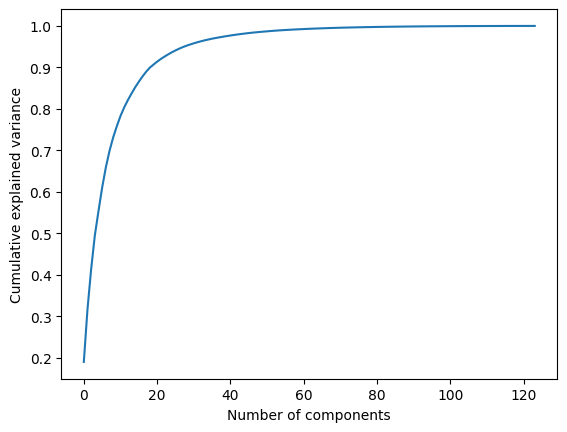

In [33]:
# Plot the explained variance

plt.plot(exp_var_cumul)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


In [34]:
training_data.head()

,match_id,esportsGameId,team_id_1,outcome_1,team_id_2,outcome_2,team_1_outcome,team_1_first_riftHerald_ind,team_1_first_riftHerald_time,team_1_num_riftHerald,...,team_2_jungle_lane_damage_to_champions_dominance_at_game_end,team_2_mid_lane_damage_to_champions_dominance_at_game_end,team_2_bot_lane_damage_to_champions_dominance_at_game_end,team_2_support_lane_damage_to_champions_dominance_at_game_end,team_2_top_lane_damage_to_buildings_dominance_at_game_end,team_2_jungle_lane_damage_to_buildings_dominance_at_game_end,team_2_mid_lane_damage_to_buildings_dominance_at_game_end,team_2_bot_lane_damage_to_buildings_dominance_at_game_end,team_2_support_lane_damage_to_buildings_dominance_at_game_end,team_2_region
0,110429332689390645,110429332689390646,101383793572656373,0,98767991926151025,1,0.500000,0.500000,502.565667,1.000000,...,0.606506,0.580308,0.609232,0.554306,0.662987,0.643732,0.819850,0.631369,0.703694,EMEA
2,110429332689390649,110429332689390650,101383793572656373,1,107563714667537640,0,0.250000,0.500000,532.797000,1.250000,...,0.464965,0.509989,0.460627,0.446400,0.534402,0.348362,0.485577,0.490636,0.488176,EMEA
3,110429332689390651,110429332689390652,101383793572656373,1,101383793569248484,0,0.428571,0.428571,502.565667,1.000000,...,0.425305,0.485137,0.363654,0.561610,0.320566,0.437748,0.567664,0.376977,0.361214,EMEA
4,110429332689390653,110429332689390654,101383793572656373,1,109637393694097670,0,0.000000,0.666667,532.797000,1.333333,...,0.504736,0.530444,0.576663,0.315533,0.306184,0.705176,0.617319,0.857179,0.893378,EMEA
5,110429332689390655,110429332689390656,103461966965149786,0,101383793572656373,1,0.800000,0.600000,487.116000,0.600000,...,0.538895,0.563655,0.471605,0.534977,0.559675,0.641821,0.477813,0.544909,0.867261,EMEA


In [57]:
# fit a random forest model on the training data
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
non_game_features = ['match_id', 'esportsGameId', 'team_id_1', 'team_id_2', 'outcome_1', 'outcome_2', 'team_1_league', 'team_2_league']
rf.fit(training_data.drop(non_game_features, axis=1), training_data['outcome_1'])

# select_game_features = ['team_1_outcome', 'team_2_outcome']
# rf.fit(training_data[select_game_features], training_data['outcome_1'])

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=0)

In [58]:
# Get the feature importances from the model
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = training_data.drop(non_game_features, axis=1).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20)

,importance
team_1_support_xp_per_min_at_14,0.005492
team_2_support_xp_per_min_at_14,0.005043
team_2_support_XP_at_14,0.004830
team_1_support_XP_at_14,0.004718
team_1_bot_CHAMPIONS_KILLED_at_20,0.004376
team_1_support_KDA_at_30,0.003580
team_1_mid_wards_per_min_at_20,0.003294
team_1_top_vision_per_min_diff_at_20,0.002827
team_1_jungle_trade_efficiency_at_14,0.002795
team_2_bot_CHAMPIONS_KILLED_at_20,0.002640


In [39]:
# Prepare the inference dataset 
# Apply the same operations as the training set w.r.t. joins, drops, and imputations with minor modifications
testing_data = testing_data.merge(rename_features(inference_game_data.drop(['platformGameId', 'start_time'], axis=1), game_features + ['league'], "team_1"), 
                                    how='left', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])
testing_data = testing_data.merge(rename_features(inference_game_data.drop(['platformGameId', 'start_time'], axis=1), game_features + ['league'], "team_2"), 
                                    how='left', 
                                    left_on=['esportsGameId', 'team_id_2'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])

# At this point all remaining nan values occur because the team has not reached a certain status yet (e.g. no first kills in any games up to that point)
# Fill these with -1
testing_data.fillna(-1, inplace=True)

# Drop the columns that were used for joining (have '_to_drop' suffix). 
testing_data.drop([x for x in testing_data.columns if '_to_drop' in x], axis=1, inplace=True)
# Drop league as we have featurized it into team_1_league and team_2_league
testing_data.drop(['league'], axis=1, inplace=True)

In [62]:
# Predict on the training data
pred_train_model = rf.predict(training_data.drop(non_game_features, axis=1))
pred_train_base = training_data['team_1_outcome'] >= training_data['team_2_outcome']

# Predict on the testing data
pred_test_model = rf.predict(testing_data.drop(non_game_features, axis=1))
pred_test_base = testing_data['team_1_outcome'] >= testing_data['team_2_outcome']

acc_train_model = np.mean(pred_train_model == training_data['outcome_1'])
acc_train_base = np.mean(pred_train_base == training_data['outcome_1'])

acc_test_model = np.mean(pred_test_model == testing_data['outcome_1'])
acc_test_base = np.mean(pred_test_base == testing_data['outcome_1'])

print(f"Train model accuracy: {acc_train_model}")
print(f"Train baseline accuracy: {acc_train_base}")

print(f"Test model accuracy: {acc_test_model}")
print(f"Test baseline accuracy: {acc_test_base}")

Train model accuracy: 1.0
Train baseline accuracy: 0.6532258064516129
Test model accuracy: 0.3125
Test baseline accuracy: 0.6875


In [56]:
# Predict on the testing data
predictions = rf.predict(testing_data[select_game_features])
base_predictions = testing_data['team_1_outcome'] >= testing_data['team_2_outcome']

acc_model = np.mean(predictions == testing_data['outcome_1'])
acc_base = np.mean(base_predictions == testing_data['outcome_1'])

print(f"Model accuracy: {acc_model}")
print(f"Baseline accuracy: {acc_base}")

Model accuracy: 0.3125
Baseline accuracy: 0.6875
